In [2]:
import cv2
import os
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import time
import pytesseract
from lib_detection import load_model, detect_lp, im2single

# load file weight, cfg, file chứa tên class (bienSo)

In [6]:
# Load Yolo
net = cv2.dnn.readNet("result/yolov3_training_last.weights", "config/yolov3_testing.cfg")
# Name custom object
classes = ["bienSo"]
with open("config/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
pytesseract.tesseract_cmd = r"tesseract-ocr-w64-setup-v5.0.0-alpha.20210506.exe"        
pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Cấu hình tham số cho model SVM

In [50]:
digit_w = 50 # Kich thuoc ki tu
digit_h = 50 # Kich thuoc ki tu

pick1 = open('SVMtrain/model.xml', 'rb')
model = pickle.load(pick1)
pick1.close()

# Định nghĩa các kí tự trên biển số

In [51]:
char_list =  '0123456789ABCDEFGHKLMNPRSTUVXYZ'


# Hàm sxep contour từ trái sang phải

In [52]:
def sort_contours(cnts):

    reverse = False
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# hàm loại bỏ các kí tự không hợp lý

In [53]:
def fine_tune(lp):
    newString = ""
    for i in range(len(lp)):
        if lp[i] in char_list:
            newString += lp[i]
    return newString

# Hàm tách và nhận diện kí tự kí tự

In [54]:

def character_separator(bienSo):
    if (len(bienSo)):

        gray = cv2.cvtColor(bienSo,cv2.COLOR_BGR2GRAY)
        # Ap dung threshold de phan tach so va nen
        binary = cv2.threshold(gray, 127, 255,
                     cv2.THRESH_BINARY_INV)[1]

        # Segment kí tự
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT , (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3, iterations = 0)

        cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        anhtam = []
        data_temp = []
        plate_info = ""
        reverse = False
        i = 0
        print(len(cont))
        for c in cont:
            (x2, y2, w2, h2) = cv2.boundingRect(c)
            ratio = h2/w2
            if 1.5<=ratio<=4: # Chon cac contour dam bao ve ratio w/h
                if h2/bienSo.shape[0]>=0.65: # Chon cac contour cao tu 65% bien so tro len

                    # Ve khung chu nhat quanh so
                    cv2.rectangle(bienSo, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 1)
                    plt.imshow( bienSo)
                    # Tach so 
                    curr_num = thre_mor[y2:y2+h2,x2:x2+w2]
                    curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                    _, curr_num = cv2.threshold(curr_num, 30, 255, cv2.THRESH_BINARY)
                    im = cv2.resize(curr_num, (50,50))
                    image = np.array(im).flatten()
                    data_temp.append(image)
                    anhtam.append(im)

        #predict
        prediction = model.predict(data_temp)
        print('Prediction is: \n', prediction)
        for i in range(len(prediction)):
            result = str(categories[prediction[i]])
            plate_info +=result
        #dao nguoc day so
        text = plate_info[::-1]
        return text
                

# Hàm tìm biển số

In [55]:
def detect(img, width, height):
    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    output_layers = net.getUnconnectedOutLayersNames()
    outs = net.forward(output_layers)

    # Showing informations on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i],2))
            color = (0, 255, 0)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)

            im = img[y:(y+h), x:(x+w)]
            plt.imshow(im)
            #gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            #text = pytesseract.image_to_string(gray, config='--psm 11')
            text = character_separator(im)
            print("Detected Number is:",text)
            #cv2.putText(img, label + " " + confidence , (x, y - 5), font, 1, color, 1)
            cv2.putText(img, fine_tune(text), (x, y - 5), font, 2, color, 1)
           # character_separator(im)

# đọc biển số trên ảnh tĩnh

13
Prediction is: 
 [ 5  7  7  5  5 15  0  3]
Detected Number is: 30F55775


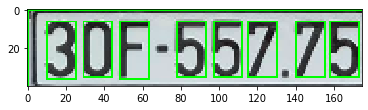

In [ ]:
img = cv2.imread(r"anhTest/f.jpg")
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape
detect(img, width, height)  
plt.figure(figsize=(16, 12))       
plt.imshow(img)

plt.show()


# Đọc biển số qua webcam

In [6]:

#lấy hình ảnh từ camera đầu tiên
cap = cv2.VideoCapture(0)
# Preparing variables for spatial dimensions of the frames
h, w = None, None


probability_minimum = 0.5
threshold = 0.3
colours = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')
f = 0
t = 0
while True:
    # Capturing frame-by-frame from camera
    ret, frame = cap.read()
    if not ret:
        break
    if w is None or h is None:
        h, w = frame.shape[:2]
    detect(frame, w, h)
        
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Detected Number is: AUS Oe

Detected Number is: 8 A-044.54

Detected Number is: 8 A-044.54,

Detected Number is: 8 A-044.54

Detected Number is: 1044.54

Detected Number is: 
Detected Number is: 
Detected Number is: 
Detected Number is: 8 A-044 54

Detected Number is: 8 A-O44 5

Detected Number is: 4-044.5/

Detected Number is: 044.54,

Detected Number is: 
Detected Number is: 044.54

Detected Number is: 
Detected Number is: 18 A-044.54|

Detected Number is: 78 A-04454

Detected Number is: 8 A-044-54

Detected Number is: 044.54,

Detected Number is: B8 A-044.54

Detected Number is: BE A-044.54'

Detected Number is: & A-044.54

Detected Number is: 
Detected Number is: 
Detected Number is: 
Detected Number is: 
Detected Number is: 
Detected Number is: 5 AN//c

Detected Number is: BAL LRT

Detected Number is: 84-044 54

Detected Number is: BAN / Fy

Detected Number is: 
Detected Number is: 3 A-044.54

Detected Number is: 
Detected Number is: 8 A-044.54)


KeyboardInterrupt: 